# Imports

In [1]:
# configure user-modules autoreload
%load_ext autoreload
%autoreload 2

import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn

# import utility functions
from train_utils import *

device

device(type='cuda', index=0)

# Data

In [2]:
import torchvision.transforms as T
from loader import get_dataloaders

# make dataloaders
TARGET_SIZE = 128


class Expand:
    def __call__(self, input_tensor):
        shapes_new = list(input_tensor.size())
        mx = max(shapes_new)
        max_size = [3, mx, mx]
        for i in range(3):
            if max_size[i] > shapes_new[i]:
                shapes_new[i] = max_size[i] - input_tensor.shape[i]
                dop_torch = torch.ones(shapes_new)
                input_tensor = torch.cat((input_tensor, dop_torch), i)
        return input_tensor


transform = T.Compose([T.ToTensor(), Expand(), T.Resize((TARGET_SIZE, TARGET_SIZE))])
train_loader, val_loader = get_dataloaders('../data', train_transform=transform, test_transform=transform, transform_name=f'Expand({TARGET_SIZE}, {TARGET_SIZE})')

# show dataset size
TRAIN_SIZE = len(train_loader.dataset)
VAL_SIZE = len(val_loader.dataset)
print(f'Train size: {TRAIN_SIZE}. Val size: {VAL_SIZE}. Val ratio: {VAL_SIZE / (TRAIN_SIZE + VAL_SIZE) * 100:.2f}%')

Train size: 6777. Val size: 2261. Val ratio: 25.02%


# Model

In [17]:
from models.lenet import get_lenet
from models.mobilenet import get_mobilenet, get_mobilenet_pretrained
from models.resnet import get_resnet18, get_resnet152
from models.efficient_net import get_efficientnet

# Make sure that model performs correctly
with torch.no_grad():
    features, labels = next(iter(train_loader))
    print(f'Features size: {features.size()}. Labels size: {labels.size()}')
    logits = get_efficientnet()(features)

Features size: torch.Size([64, 3, 128, 128]). Labels size: torch.Size([64])


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to C:\Users\Maksim/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:06<00:00, 3.17MB/s]


# Training

Train accuracy: 99.2%. Val accuracy: 87.4%
Train score: 7.88. Val score: 5.96
Train loss: 0.03. Val loss: 0.55


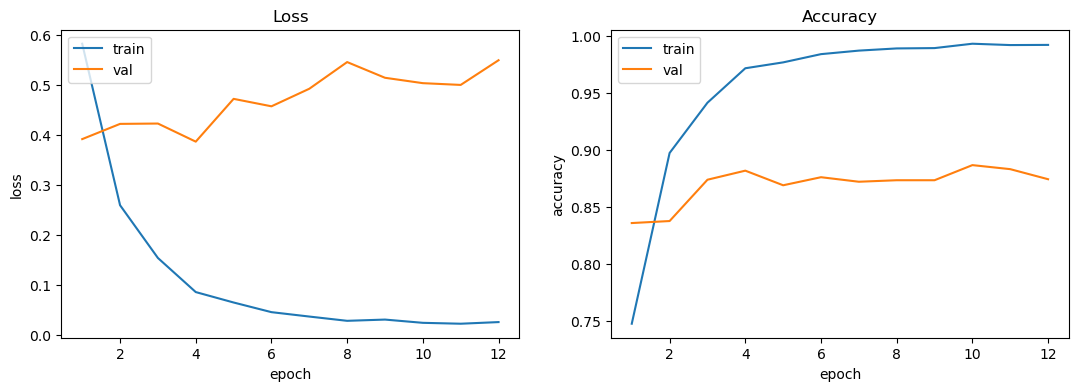

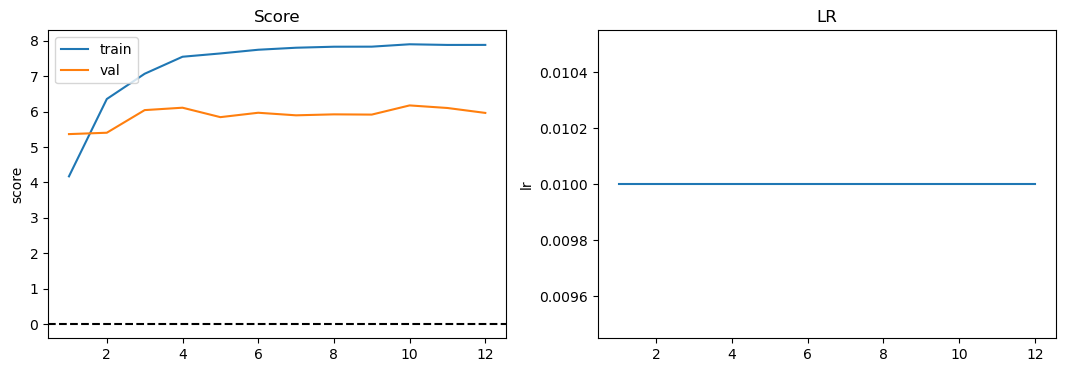

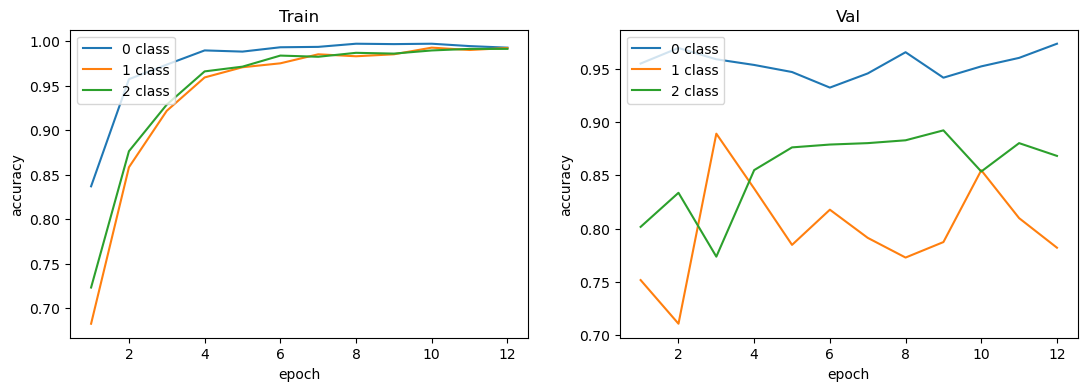

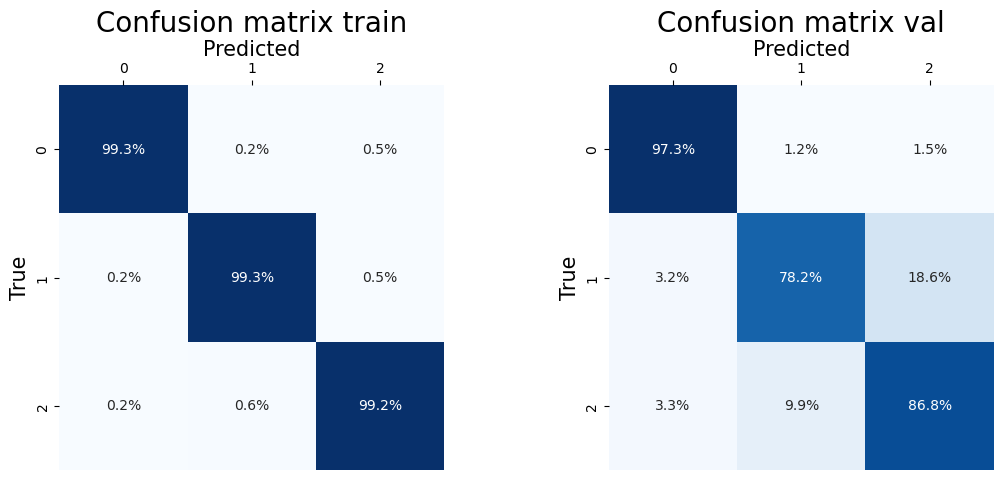

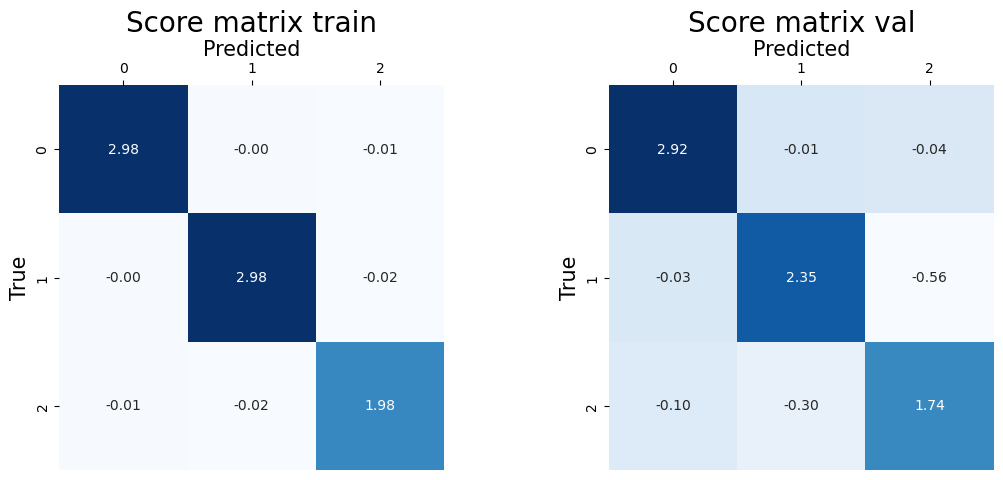

Training:   0%|          | 0/106 [00:00<?, ?it/s]

In [18]:
# import one of the criterions
from criterions import CrossEntropyLoss
from train_utils import *

LOG_WANDB = False
N_EPOCHS = 60

FACTOR = 0.3
PATIENCE = 3

model = get_efficientnet().to(device)

LR = 1e-2
MOMENTUM = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=0.0001)
scheduler = None  # torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=FACTOR, patience=PATIENCE)
criterion = CrossEntropyLoss()

if LOG_WANDB:
    experiment_name = f'LeNet128'
    notes = f'''
    Optimizer: SGD({LR=}, {MOMENTUM=})
    Scheduler: ReduceLROnPlateau({FACTOR=}, {PATIENCE=})
    '''
    wandb.login()
    wandb.init(
        project='VK Hackathon',
        name=experiment_name,
        notes=notes
    )

try:
    torch.manual_seed(0)
    train_nn(model, optimizer, criterion, scheduler, train_loader=train_loader, val_loader=val_loader, n_epochs=N_EPOCHS, log_wandb=LOG_WANDB)
except KeyboardInterrupt:
    print('KeyboardInterrupt')
    if LOG_WANDB:
        wandb.finish()

print('Success')